# Feature creation and EDA

In [1]:
# import libraries

import geopandas as gpd
import pandas as pd
from shapely import wkt

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

## Main Dataset - Scondary electricity Supply Area

In [2]:
## Main dataset
gpkg_file_path = 'OCC_Secondary_Substations_ESAs.gpkg'
ESA = gpd.read_file(gpkg_file_path)

# deal with missing values
ESA.replace(-123456, np.nan, inplace=True)

print(ESA.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6007 entries, 0 to 6006
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   SEC_SUB_NUMBER  4720 non-null   object  
 1   SEC_SUB_NAME    4716 non-null   object  
 2   Area            4720 non-null   object  
 3   DNO             6007 non-null   object  
 4   Flag_SubDesign  4720 non-null   object  
 5   CapacityRating  4720 non-null   float64 
 6   peakload        4720 non-null   float64 
 7   Headroom        4720 non-null   float64 
 8   % headroom      4720 non-null   float64 
 9   Demand_rag      6007 non-null   object  
 10  latitude        4672 non-null   float64 
 11  longitude       4672 non-null   float64 
 12  geometry        6007 non-null   geometry
dtypes: float64(6), geometry(1), object(6)
memory usage: 610.2+ KB
None


### EDA for main dataset

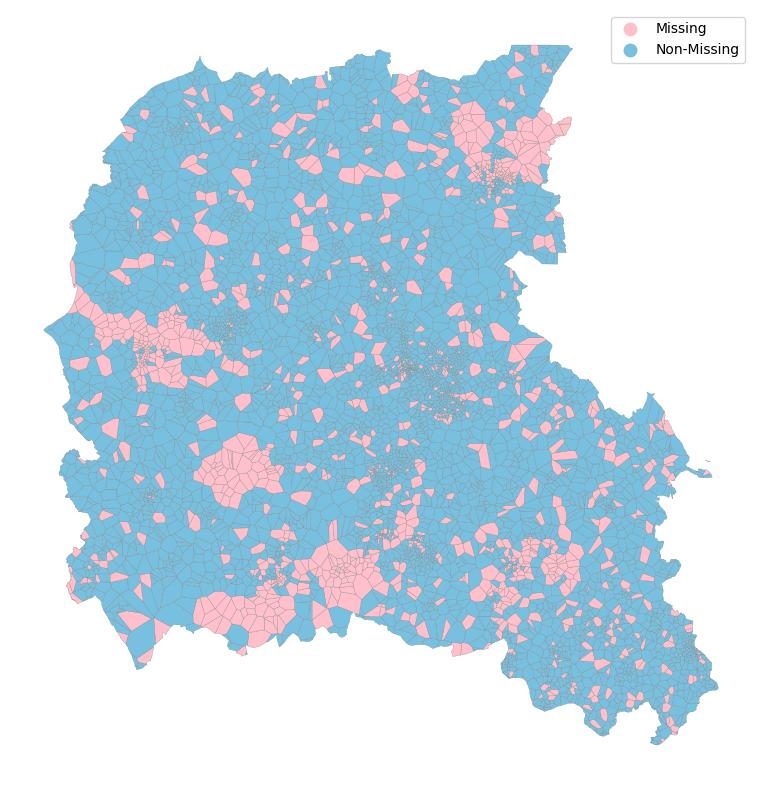

In [3]:
# new column for missing data points
ESA['missing'] = np.where(ESA['peakload'].isna(), 'Missing', 'Non-Missing')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

# Define colormap
cmap = mcolors.ListedColormap(['pink', '#78c0e0'])
norm = mcolors.BoundaryNorm([0, 1], cmap.N)

# Plot the map
ESA.plot(column='missing', cmap=cmap, linewidth=0.2, edgecolor='grey', ax=ax, legend=True, norm=norm)
ax.set_axis_off()

# Show the plot
plt.show()

In [4]:
# statistic summary for capacity rating and peak load
ESA[['CapacityRating', 'peakload']].describe()

,CapacityRating,peakload
count,4720.000000,4720.000000
mean,271.209958,95.732792
std,254.517376,122.745617
min,1.000000,0.000000
25%,50.000000,10.877500
50%,200.000000,51.725000
75%,500.000000,149.497500
max,1500.000000,4053.340000


In [5]:
# one data point with to extreme values
ESA_extreme = ESA[ESA['peakload']>1000]
ESA_filtered = ESA[ESA['peakload']<=1000]

# ESA_extreme
# There only on point in ESA_extreme and the Peak Load in this data point is over 4000

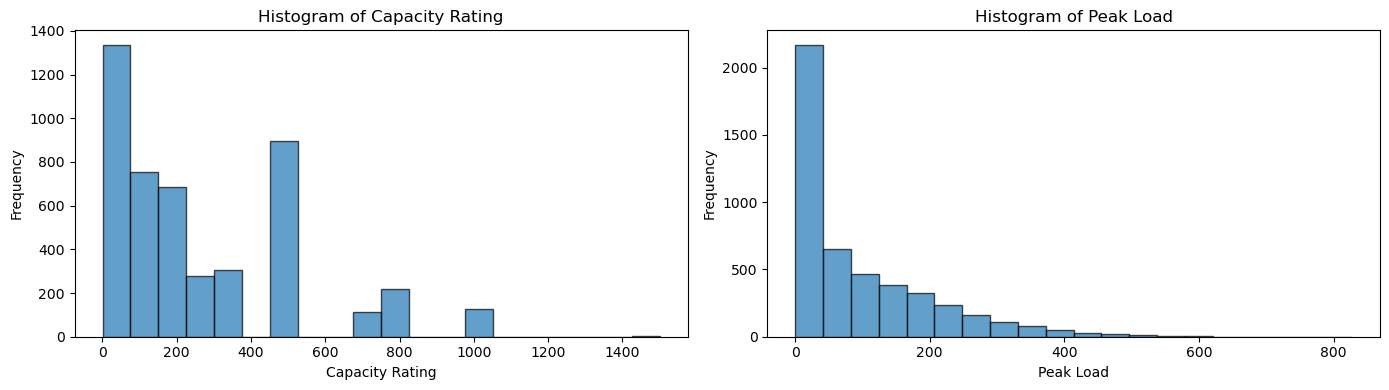

In [6]:
# Histograms of targets
plt.figure(figsize=(14, 4))

# Histogram of Capacity Rating
plt.subplot(1, 2, 1)
plt.hist(ESA_filtered['CapacityRating'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Capacity Rating')
plt.xlabel('Capacity Rating')
plt.ylabel('Frequency')
plt.grid(False)

# Histogram of Peak Load
plt.subplot(1, 2, 2)
plt.hist(ESA_filtered['peakload'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Peak Load')
plt.xlabel('Peak Load')
plt.ylabel('Frequency')
plt.grid(False)

# Show plots
plt.tight_layout()
plt.show()

In [7]:
# Re-project to the projected CRS
projected_crs = "EPSG:3395"
ESA_projected = ESA.to_crs(projected_crs)

# area calculation
ESA_projected['area_ESA'] = ESA_projected.geometry.area

### Merge ESA with building dataset using OS Address Base

In [8]:
# CSV file path
csv_file_path = 'OCC_OS_AddressBase_Premium.csv'
OS_csv = pd.read_csv(csv_file_path, encoding='latin1')

# deal with missing values
OS_csv.replace(-123456, np.nan, inplace=True)

# print(OS_csv.head())
# OS_csv.info()

In [9]:
# Convert the geometry column to geometric objects
OS_csv['geometry'] = OS_csv['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
OS = gpd.GeoDataFrame(OS_csv, geometry='geometry')
OS = OS.set_crs("EPSG:4326")

# re-project to the projected CRS
projected_crs = "EPSG:3395"
OS_projected = OS.to_crs(projected_crs)

# calculate the OS area
OS_projected['area_OS'] = OS_projected.geometry.area

#print(OS_projected.info())
OS_projected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 387072 entries, 0 to 387071
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Absolute Height - Max        384795 non-null  float64 
 1   Area                         387072 non-null  float64 
 2   Child UPRNs                  387072 non-null  float64 
 3   Class Description            387072 non-null  object  
 4   Classification Code          387072 non-null  object  
 5   Easting                      387072 non-null  float64 
 6   Latitude                     387072 non-null  float64 
 7   Longitude                    387072 non-null  float64 
 8   Northing                     387072 non-null  float64 
 9   Organisation                 387072 non-null  object  
 10  Organisation - Last Updated  387072 non-null  object  
 11  Parent UPRN                  69425 non-null   float64 
 12  Post Code                    387072 

In [10]:
# merge ESA and OS
ESA_OS = gpd.sjoin(ESA_projected, OS_projected, how="left", predicate='intersects')
#ESA_OS.info()

# Calculate the building number with different building type
ESA_OS['Residential_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'R' else 0)
ESA_OS['Commercial_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'C' else 0)
ESA_OS['Parent Shell_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'P' else 0)
ESA_OS['Dual Use_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'X' else 0)
ESA_OS['Land_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'L' else 0)
ESA_OS['Other_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'O' else 0)
ESA_OS['Object of Interest_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'Z' else 0)
ESA_OS['Unclassified_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'U' else 0)
ESA_OS['Military_num'] = ESA_OS['Primary Code'].apply(lambda x: 1 if x == 'M' else 0)

# Calculate the building area with different building type
area_mapping = {
    'R': 'Residential_area',
    'C': 'Commercial_area',
    'P': 'Parent Shell_area',
    'X': 'Dual Use_area',
    'L': 'Land_area',
    'O': 'Other_area',
    'Z': 'Object of Interest_area',
    'U': 'Unclassified_area',
    'M': 'Military_area'
}

for code, column in area_mapping.items():
    ESA_OS[column] = ESA_OS['area_OS'].where(ESA_OS['Primary Code'] == code, 0)


In [11]:
# Sum the building number and area with differnt building types in each ESA
agg_data = ESA_OS[['Residential_num','Commercial_num','Parent Shell_num','Dual Use_num','Land_num',
                   'Other_num','Object of Interest_num','Unclassified_num','Military_num',
                   'Residential_area','Commercial_area','Parent Shell_area','Dual Use_area','Land_area',
                   'Other_area','Object of Interest_area','Unclassified_area','Military_area']]
building = agg_data.groupby(agg_data.index).sum()
building.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6007 entries, 0 to 6006
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Residential_num          6007 non-null   int64  
 1   Commercial_num           6007 non-null   int64  
 2   Parent Shell_num         6007 non-null   int64  
 3   Dual Use_num             6007 non-null   int64  
 4   Land_num                 6007 non-null   int64  
 5   Other_num                6007 non-null   int64  
 6   Object of Interest_num   6007 non-null   int64  
 7   Unclassified_num         6007 non-null   int64  
 8   Military_num             6007 non-null   int64  
 9   Residential_area         6007 non-null   float64
 10  Commercial_area          6007 non-null   float64
 11  Parent Shell_area        6007 non-null   float64
 12  Dual Use_area            6007 non-null   float64
 13  Land_area                6007 non-null   float64
 14  Other_area               6007

In [12]:
# Merge ESA with its building number and area
ESA_building = ESA_projected.merge(building, left_index=True, right_index=True, how='inner')
ESA_building.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6007 entries, 0 to 6006
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   SEC_SUB_NUMBER           4720 non-null   object  
 1   SEC_SUB_NAME             4716 non-null   object  
 2   Area                     4720 non-null   object  
 3   DNO                      6007 non-null   object  
 4   Flag_SubDesign           4720 non-null   object  
 5   CapacityRating           4720 non-null   float64 
 6   peakload                 4720 non-null   float64 
 7   Headroom                 4720 non-null   float64 
 8   % headroom               4720 non-null   float64 
 9   Demand_rag               6007 non-null   object  
 10  latitude                 4672 non-null   float64 
 11  longitude                4672 non-null   float64 
 12  geometry                 6007 non-null   geometry
 13  missing                  6007 non-null   object  
 14  

## Non-Domestic electricity consumption with MSOA

In [13]:
## MSOA dataset
file_path = 'elec_non-domestic_MSOA_stacked_2010-22.csv'
MSOA_csv = pd.read_csv(file_path, encoding='latin-1')
MSOA_2022 = MSOA_csv[MSOA_csv['Year'] == 2022]
# print(MSOA_2022.info())

## MSOA boundries
gpkg_file_path = 'Middle_layer_Super_Output_Areas_December_2021_Boundaries_EW_BSC_V3_2667861458326012546.gpkg'
MSOA_boundary = gpd.read_file(gpkg_file_path)

MSOA_df = MSOA_2022.merge(MSOA_boundary, left_on='MSOA_code', right_on='MSOA21CD')

MSOA = gpd.GeoDataFrame(MSOA_df, geometry='geometry')
MSOA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7264 entries, 0 to 7263
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Year                              7264 non-null   int64   
 1   LA_code                           7264 non-null   object  
 2   LA                                7264 non-null   object  
 3   MSOA_code                         7264 non-null   object  
 4   MSOA                              7264 non-null   object  
 5   Meter_type                        7264 non-null   object  
 6   Meters                            7264 non-null   float64 
 7   Consumption_kWh                   7264 non-null   float64 
 8   Mean_consumption_kWh_per_meter    7264 non-null   float64 
 9   Median_consumption_kWh_per_meter  7264 non-null   float64 
 10  MSOA21CD                          7264 non-null   object  
 11  MSOA21NM                          7264 non-null 

In [14]:
# Re-project to the projected CRS
projected_crs = "EPSG:3395"
MSOA_projected = MSOA.to_crs(projected_crs)

# area calculation
MSOA_projected['area_MSOA'] = MSOA_projected.geometry.area
# MSOA_projected.head()

### Add building information into MSOA with OS dataset

In [15]:
# merge MSOA and OS
MSOA_OS = gpd.sjoin(MSOA_projected, OS_projected, how="left", predicate='intersects')

# Building number
MSOA_OS['Residential_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'R' else 0)
MSOA_OS['Commercial_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'C' else 0)
MSOA_OS['Parent Shell_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'P' else 0)
MSOA_OS['Dual Use_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'X' else 0)
MSOA_OS['Land_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'L' else 0)
MSOA_OS['Other_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'O' else 0)
MSOA_OS['Object of Interest_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'Z' else 0)
MSOA_OS['Unclassified_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'U' else 0)
MSOA_OS['Military_MSOA'] = MSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'M' else 0)

# Building area
area_mapping = {
    'R': 'Residential_area_M',
    'C': 'Commercial_area_M',
    'P': 'Parent Shell_area_M',
    'X': 'Dual Use_area_M',
    'L': 'Land_area_M',
    'O': 'Other_area_M',
    'Z': 'Object of Interest_area_M',
    'U': 'Unclassified_area_M',
    'M': 'Military_area_M'
}
for code, column in area_mapping.items():
    MSOA_OS[column] = MSOA_OS['area_OS'].where(MSOA_OS['Primary Code'] == code, 0)

# Sum up
agg_data = MSOA_OS[['Residential_MSOA','Commercial_MSOA','Parent Shell_MSOA','Dual Use_MSOA','Land_MSOA',
                    'Other_MSOA','Object of Interest_MSOA','Unclassified_MSOA','Military_MSOA',
                    'Residential_area_M','Commercial_area_M','Parent Shell_area_M','Dual Use_area_M','Land_area_M',
                    'Other_area_M','Object of Interest_area_M','Unclassified_area_M','Military_area_M']]
building = agg_data.groupby(agg_data.index).sum()

MSOA_building = pd.concat([MSOA_projected, building], axis=1)
MSOA_building.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7264 entries, 0 to 7263
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Year                              7264 non-null   int64   
 1   LA_code                           7264 non-null   object  
 2   LA                                7264 non-null   object  
 3   MSOA_code                         7264 non-null   object  
 4   MSOA                              7264 non-null   object  
 5   Meter_type                        7264 non-null   object  
 6   Meters                            7264 non-null   float64 
 7   Consumption_kWh                   7264 non-null   float64 
 8   Mean_consumption_kWh_per_meter    7264 non-null   float64 
 9   Median_consumption_kWh_per_meter  7264 non-null   float64 
 10  MSOA21CD                          7264 non-null   object  
 11  MSOA21NM                          7264 non-null 

In [16]:
MSOA_building['Non_Domestic_km2_C'] = MSOA_building['Consumption_kWh'] / MSOA_building['Commercial_area_M'].replace(0, pd.NA)
MSOA_building['Non_Domestic_building_C'] = MSOA_building['Consumption_kWh'] / MSOA_building['Commercial_MSOA'].replace(0, pd.NA)

### Merge ESA, MSOA with building data

In [17]:
joined_gdf = gpd.sjoin(ESA_building, MSOA_building, how="left", predicate='intersects')

# Citation: Nestler, J. B. (2020, August 17). How to find geometry intersections within the same dataset using GeoPandas. Medium. 
# https://medium.com/@jesse.b.nestler/how-to-find-geometry-intersections-within-the-same-dataset-using-geopandas-59cd1a5f30f9
# Calculate intersection areas
def calculate_intersection(row):
    if pd.notnull(row['index_right']):
        intersected_geometry = row.geometry.intersection(MSOA_building.loc[row['index_right']].geometry)
        return intersected_geometry
    else:
        return None

joined_gdf['intersection'] = joined_gdf.apply(calculate_intersection, axis=1)

# Calculate intersection percentage
joined_gdf['intersection_area'] = joined_gdf['intersection'].apply(lambda x: x.area if x else 0)
joined_gdf['intersection_percent_ESA'] = joined_gdf['intersection_area']/joined_gdf['area_ESA']

joined_gdf['sum_intersection_percent_ESA'] = joined_gdf.groupby(joined_gdf.index)['intersection_percent_ESA'].transform('sum')
joined_gdf['weight'] = joined_gdf['intersection_percent_ESA']/joined_gdf['sum_intersection_percent_ESA']

In [18]:
joined_gdf['Non_Domestic_consumption_area_C'] = joined_gdf['Non_Domestic_km2_C']*joined_gdf['Commercial_area']*joined_gdf['weight']
joined_gdf['Non_Domestic_consumption_building_C'] = joined_gdf['Non_Domestic_building_C']*joined_gdf['Commercial_num']*joined_gdf['weight']

agg_data = joined_gdf[['Non_Domestic_consumption_area_C','Non_Domestic_consumption_building_C']]
MSOA_features = agg_data.groupby(agg_data.index).sum()
MSOA_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6007 entries, 0 to 6006
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Non_Domestic_consumption_area_C      6007 non-null   object
 1   Non_Domestic_consumption_building_C  6007 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


## Domestic electricity consumption with LSOA

In [19]:
# LSOA dataset
file_path = 'elec_domestic_LSOA_stacked_2010-22.csv'
LSOA_csv = pd.read_csv(file_path, encoding='latin-1')
LSOA_2022 = LSOA_csv[LSOA_csv['Year'] == 2022]

# LSOA boundary
gpkg_file_path = 'Lower_layer_Super_Output_Areas_December_2021_Boundaries_EW_BSC_V4_4601361198979128639.gpkg'
LSOA_boundary = gpd.read_file(gpkg_file_path)

LSOA_df = LSOA_2022.merge(LSOA_boundary, left_on='LSOA_code', right_on='LSOA21CD')
LSOA = gpd.GeoDataFrame(LSOA_df, geometry='geometry')

# Re-project to the projected CRS
projected_crs = "EPSG:3395"
LSOA_projected = LSOA.to_crs(projected_crs)

# area calculation
LSOA_projected['area_LSOA'] = LSOA_projected.geometry.area
LSOA_projected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Year                              35672 non-null  int64   
 1   LA_code                           35672 non-null  object  
 2   LA                                35672 non-null  object  
 3   MSOA_code                         35672 non-null  object  
 4   MSOA                              35672 non-null  object  
 5   LSOA_code                         35672 non-null  object  
 6   LSOA                              35672 non-null  object  
 7   Meters                            35671 non-null  float64 
 8   Consumption_kWh                   35671 non-null  float64 
 9   Mean_consumption_kWh_per_meter    35671 non-null  float64 
 10  Median_consumption_kWh_per_meter  35671 non-null  float64 
 11  LSOA21CD                          35672 non-nu

### Add building information into LSOA with OS dataset

In [20]:
# merge LSOA and OS
LSOA_OS = gpd.sjoin(LSOA_projected, OS_projected, how="left", predicate='intersects')

# building numbers
LSOA_OS['Residential_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'R' else 0)
LSOA_OS['Commercial_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'C' else 0)
LSOA_OS['Parent Shell_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'P' else 0)
LSOA_OS['Dual Use_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'X' else 0)
LSOA_OS['Land_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'L' else 0)
LSOA_OS['Other_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'O' else 0)
LSOA_OS['Object of Interest_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'Z' else 0)
LSOA_OS['Unclassified_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'U' else 0)
LSOA_OS['Military_LSOA'] = LSOA_OS['Primary Code'].apply(lambda x: 1 if x == 'M' else 0)

# building areas
area_mapping = {
    'R': 'Residential_area_L',
    'C': 'Commercial_area_L',
    'P': 'Parent Shell_area_L',
    'X': 'Dual Use_area_L',
    'L': 'Land_area_L',
    'O': 'Other_area_L',
    'Z': 'Object of Interest_area_L',
    'U': 'Unclassified_area_L',
    'M': 'Military_area_L'
}

for code, column in area_mapping.items():
    LSOA_OS[column] = LSOA_OS['area_OS'].where(LSOA_OS['Primary Code'] == code, 0)

# Sum up
agg_data = LSOA_OS[['Residential_LSOA','Commercial_LSOA','Parent Shell_LSOA','Dual Use_LSOA','Land_LSOA',
                    'Other_LSOA','Object of Interest_LSOA','Unclassified_LSOA','Military_LSOA',
                    'Residential_area_L','Commercial_area_L','Parent Shell_area_L','Dual Use_area_L','Land_area_L',
                    'Other_area_L','Object of Interest_area_L','Unclassified_area_L','Military_area_L']]
building = agg_data.groupby(agg_data.index).sum()

# merge LSOA with its building information
LSOA_building = pd.concat([LSOA_projected, building], axis=1)

LSOA_building['Domestic_km2'] = LSOA_building['Consumption_kWh'] / LSOA_building['Residential_area_L'].replace(0, pd.NA)
LSOA_building['Domestic_building'] = LSOA_building['Consumption_kWh'] / LSOA_building['Residential_LSOA'].replace(0, pd.NA)

### Merge ESA, LSOA with building data¶

In [21]:
# merge ESA and LSOA
joined_gdf = gpd.sjoin(ESA_building, LSOA_building, how="left", predicate='intersects')

# Citation: Nestler, J. B. (2020, August 17). How to find geometry intersections within the same dataset using GeoPandas. Medium. 
# https://medium.com/@jesse.b.nestler/how-to-find-geometry-intersections-within-the-same-dataset-using-geopandas-59cd1a5f30f9
# Calculate intersection areas
def calculate_intersection(row):
    if pd.notnull(row['index_right']):
        intersected_geometry = row.geometry.intersection(LSOA_building.loc[row['index_right']].geometry)
        return intersected_geometry
    else:
        return None

joined_gdf['intersection'] = joined_gdf.apply(calculate_intersection, axis=1)

# Calculate area of intersections percentage in ESA
joined_gdf['intersection_area'] = joined_gdf['intersection'].apply(lambda x: x.area if x else 0)
joined_gdf['intersection_percent_ESA'] = joined_gdf['intersection_area']/joined_gdf['area_ESA']

joined_gdf['sum_intersection_percent_ESA'] = joined_gdf.groupby(joined_gdf.index)['intersection_percent_ESA'].transform('sum')
joined_gdf['weight'] = joined_gdf['intersection_percent_ESA']/joined_gdf['sum_intersection_percent_ESA']

In [22]:
joined_gdf['Domestic_consumption_area'] = joined_gdf['Domestic_km2']*joined_gdf['Residential_area']*joined_gdf['weight']
joined_gdf['Domestic_consumption_building'] = joined_gdf['Domestic_building']*joined_gdf['Residential_num']*joined_gdf['weight']

agg_data = joined_gdf[['Domestic_consumption_area','Domestic_consumption_building']]

agg_data = joined_gdf[['Domestic_consumption_area','Domestic_consumption_building']]
LSOA_features = agg_data.groupby(agg_data.index).sum()
LSOA_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6007 entries, 0 to 6006
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Domestic_consumption_area      6007 non-null   object
 1   Domestic_consumption_building  6007 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


## Domestic electricity consumption with postcode

In [23]:
# Postcode datasets
gpkg_file_path = 'postcode.gpkg'

postcode = gpd.read_file(gpkg_file_path)

postcode.replace(-123456, np.nan, inplace=True)

# Re-project to the projected CRS
projected_crs = "EPSG:3395"
postcode_projected = postcode.to_crs(projected_crs)

# area calculation
postcode_projected['area_postcode'] = postcode_projected.geometry.area

postcode_projected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15249 entries, 0 to 15248
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ogc_fid          15249 non-null  int64   
 1   Outcode          15249 non-null  object  
 2   Postcode         15249 non-null  object  
 3   Num_meters       15249 non-null  int64   
 4   Total_cons_kwh   15249 non-null  float64 
 5   Mean_cons_kwh    15249 non-null  float64 
 6   Median_cons_kwh  15249 non-null  float64 
 7   geometry         15249 non-null  geometry
 8   area_postcode    15249 non-null  float64 
dtypes: float64(4), geometry(1), int64(2), object(2)
memory usage: 1.0+ MB


### Merge ESA with postcode

In [24]:
# merge ESA and postcode
joined_gdf = gpd.sjoin(ESA_projected, postcode_projected, how="left", predicate='intersects')

# Citation: Nestler, J. B. (2020, August 17). How to find geometry intersections within the same dataset using GeoPandas. Medium. 
# https://medium.com/@jesse.b.nestler/how-to-find-geometry-intersections-within-the-same-dataset-using-geopandas-59cd1a5f30f9
# Calculate intersection areas
def calculate_intersection(row):
    if pd.notnull(row['index_right']):
        intersected_geometry = row.geometry.intersection(postcode_projected.loc[row['index_right']].geometry)
        return intersected_geometry
    else:
        return None

joined_gdf['intersection'] = joined_gdf.apply(calculate_intersection, axis=1)

# Calculate area of intersections percentage in postcode
joined_gdf['intersection_area'] = joined_gdf['intersection'].apply(lambda x: x.area if x else 0)
joined_gdf['intersection_percent'] = joined_gdf['intersection_area']/joined_gdf['area_postcode']

# Calculate postcode consumption in each ESA
joined_gdf['Consumption_postcode'] = joined_gdf['Total_cons_kwh'] * joined_gdf['intersection_percent']

agg_data = joined_gdf[['Consumption_postcode']]
postcode_features = agg_data.groupby(agg_data.index).sum()
print(postcode_features.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6007 entries, 0 to 6006
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consumption_postcode  6007 non-null   float64
dtypes: float64(1)
memory usage: 93.9 KB
None


### Population with CV dataset

In [25]:
## CV dataset
gpkg_file_path = 'OCC_Vulnerable_Consumer_Data.gpkg'
CV = gpd.read_file(gpkg_file_path)

# deal with missing values
CV.replace(-123456, np.nan, inplace=True)

# Re-project to the projected CRS
projected_crs = "EPSG:3395"
CV_projected = CV.to_crs(projected_crs)

# area calculation
CV_projected['area_CV'] = CV_projected.geometry.area

print(CV_projected.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 41 columns):
 #   Column                                                           Non-Null Count  Dtype   
---  ------                                                           --------------  -----   
 0   id                                                               430 non-null    object  
 1   lsoa.name                                                        430 non-null    object  
 2   la.code                                                          430 non-null    object  
 3   Community resilience: score (higher=low resilience)              430 non-null    float64 
 4   Social isolation: score (higher=more isolated)                   430 non-null    float64 
 5   Population                                                       430 non-null    float64 
 6   Number of households                                             430 non-null    float64 
 7   Under 5 years              

### Merge with OS data to gain building information

In [26]:
CV_OS = gpd.sjoin(CV_projected, OS_projected, how="left", predicate='intersects')

# Building number
CV_OS['Residential_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'R' else 0)
CV_OS['Commercial_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'C' else 0)
CV_OS['Parent Shell_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'P' else 0)
CV_OS['Dual Use_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'X' else 0)
CV_OS['Land_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'L' else 0)
CV_OS['Other_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'O' else 0)
CV_OS['Object of Interest_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'Z' else 0)
CV_OS['Unclassified_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'U' else 0)
CV_OS['Military_CV'] = CV_OS['Primary Code'].apply(lambda x: 1 if x == 'M' else 0)

# building area
area_mapping = {
    'R': 'Residential_area_CV',
    'C': 'Commercial_area_CV',
    'P': 'Parent Shell_area_CV',
    'X': 'Dual Use_area_CV',
    'L': 'Land_area_CV',
    'O': 'Other_area_CV',
    'Z': 'Object of Interest_area_CV',
    'U': 'Unclassified_area_CV',
    'M': 'Military_area_CV'
}
for code, column in area_mapping.items():
    CV_OS[column] = CV_OS['area_OS'].where(CV_OS['Primary Code'] == code, 0)

# sum up
agg_data = CV_OS[['Residential_CV','Commercial_CV','Parent Shell_CV','Dual Use_CV',
                  'Land_CV','Other_CV','Object of Interest_CV','Unclassified_CV','Military_CV',
                  'Residential_area_CV','Commercial_area_CV','Parent Shell_area_CV','Dual Use_area_CV',
                  'Land_area_CV','Other_area_CV','Object of Interest_area_CV','Unclassified_area_CV',
                  'Military_area_CV']]
building = agg_data.groupby(agg_data.index).sum()

# CV with building information
CV_building = CV_projected.merge(building, left_index=True, right_index=True, how='inner')

CV_building['PeoplePerBuilding'] = CV_building['Population']/CV_building['Residential_CV'].replace(0, pd.NA)
CV_building['PeoplePerKM2'] = (CV_building['Population']/CV_building['Residential_area_CV'].replace(0, pd.NA))

CV_building.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 61 columns):
 #   Column                                                           Non-Null Count  Dtype   
---  ------                                                           --------------  -----   
 0   id                                                               430 non-null    object  
 1   lsoa.name                                                        430 non-null    object  
 2   la.code                                                          430 non-null    object  
 3   Community resilience: score (higher=low resilience)              430 non-null    float64 
 4   Social isolation: score (higher=more isolated)                   430 non-null    float64 
 5   Population                                                       430 non-null    float64 
 6   Number of households                                             430 non-null    float64 
 7   Under 5 years              

### Merge ESA and CV to define population in each ESA

In [27]:
joined_gdf = gpd.sjoin(ESA_building, CV_building, how="left", predicate='intersects')

# Citation: Nestler, J. B. (2020, August 17). How to find geometry intersections within the same dataset using GeoPandas. Medium. 
# https://medium.com/@jesse.b.nestler/how-to-find-geometry-intersections-within-the-same-dataset-using-geopandas-59cd1a5f30f9
# Calculate intersection areas
def calculate_intersection(row):
    if pd.notnull(row['index_right']):
        intersected_geometry = row.geometry.intersection(CV_projected.loc[row['index_right']].geometry)
        return intersected_geometry
    else:
        return None

joined_gdf['intersection'] = joined_gdf.apply(calculate_intersection, axis=1)

# Calculate area of intersections percentage in ESA
joined_gdf['intersection_area'] = joined_gdf['intersection'].apply(lambda x: x.area if x else 0)
joined_gdf['intersection_percent_ESA'] = joined_gdf['intersection_area']/joined_gdf['area_ESA']

In [28]:
# Calculate weighted with intersection percent
joined_gdf['sum_intersection_percent_ESA'] = joined_gdf.groupby(joined_gdf.index)['intersection_percent_ESA'].transform('sum')
joined_gdf['weight'] = joined_gdf['intersection_percent_ESA']/joined_gdf['sum_intersection_percent_ESA']

# Calculate the population by residential buildings
joined_gdf['Population_building'] = joined_gdf['PeoplePerBuilding']*joined_gdf['Residential_num']*joined_gdf['intersection_percent_ESA']
joined_gdf['Population_areas'] = joined_gdf['PeoplePerKM2']*joined_gdf['Residential_area']*joined_gdf['intersection_percent_ESA']

agg_data = joined_gdf[['Population_building','Population_areas']]

CV_features = agg_data.groupby(agg_data.index).sum()
CV_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6007 entries, 0 to 6006
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Population_building  6007 non-null   object
 1   Population_areas     6007 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


## Calculate builing numbers and density with ESA_building dataset

In [29]:
# Total building numbers and building areas
ESA_building['All building_num'] = (
    ESA_building['Residential_num'] + ESA_building['Commercial_num'] + ESA_building['Parent Shell_num'] + 
    ESA_building['Dual Use_num'] + ESA_building['Land_num'] + ESA_building['Other_num'] +
    ESA_building['Object of Interest_num'] + ESA_building['Unclassified_num'] + ESA_building['Military_num']
)

ESA_building['All building_area'] = (
    ESA_building['Residential_area'] + ESA_building['Commercial_area'] + ESA_building['Parent Shell_area'] + 
    ESA_building['Dual Use_area'] + ESA_building['Land_area'] + ESA_building['Other_area'] +
    ESA_building['Object of Interest_area'] + ESA_building['Unclassified_area'] + ESA_building['Military_area']
)

# Building density
ESA_building['building_density_number'] = (ESA_building['All building_num']/ESA_building['area_ESA'])*1e6
ESA_building['building_density_area'] = (ESA_building['All building_area']/ESA_building['area_ESA'])

OS_features = ESA_building[['All building_num', 'All building_area', 'building_density_number', 'building_density_area']]
OS_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6007 entries, 0 to 6006
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   All building_num         6007 non-null   int64  
 1   All building_area        6007 non-null   float64
 2   building_density_number  6007 non-null   float64
 3   building_density_area    6007 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 187.8 KB


## Merge all features

In [30]:
ESA_features = pd.concat([ESA, MSOA_features, LSOA_features, postcode_features, CV_features, OS_features], axis=1)

ESA_features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6007 entries, 0 to 6006
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   SEC_SUB_NUMBER                       4720 non-null   object  
 1   SEC_SUB_NAME                         4716 non-null   object  
 2   Area                                 4720 non-null   object  
 3   DNO                                  6007 non-null   object  
 4   Flag_SubDesign                       4720 non-null   object  
 5   CapacityRating                       4720 non-null   float64 
 6   peakload                             4720 non-null   float64 
 7   Headroom                             4720 non-null   float64 
 8   % headroom                           4720 non-null   float64 
 9   Demand_rag                           6007 non-null   object  
 10  latitude                             4672 non-null   float64 
 11  longitude

In [31]:
ESA_features['Non_Domestic_consumption_building_C'] = pd.to_numeric(ESA_features['Non_Domestic_consumption_building_C'], errors='coerce')
ESA_features['Domestic_consumption_building'] = pd.to_numeric(ESA_features['Domestic_consumption_building'], errors='coerce')
ESA_features['Population_building'] = pd.to_numeric(ESA_features['Population_building'], errors='coerce')

### Pearson correlation

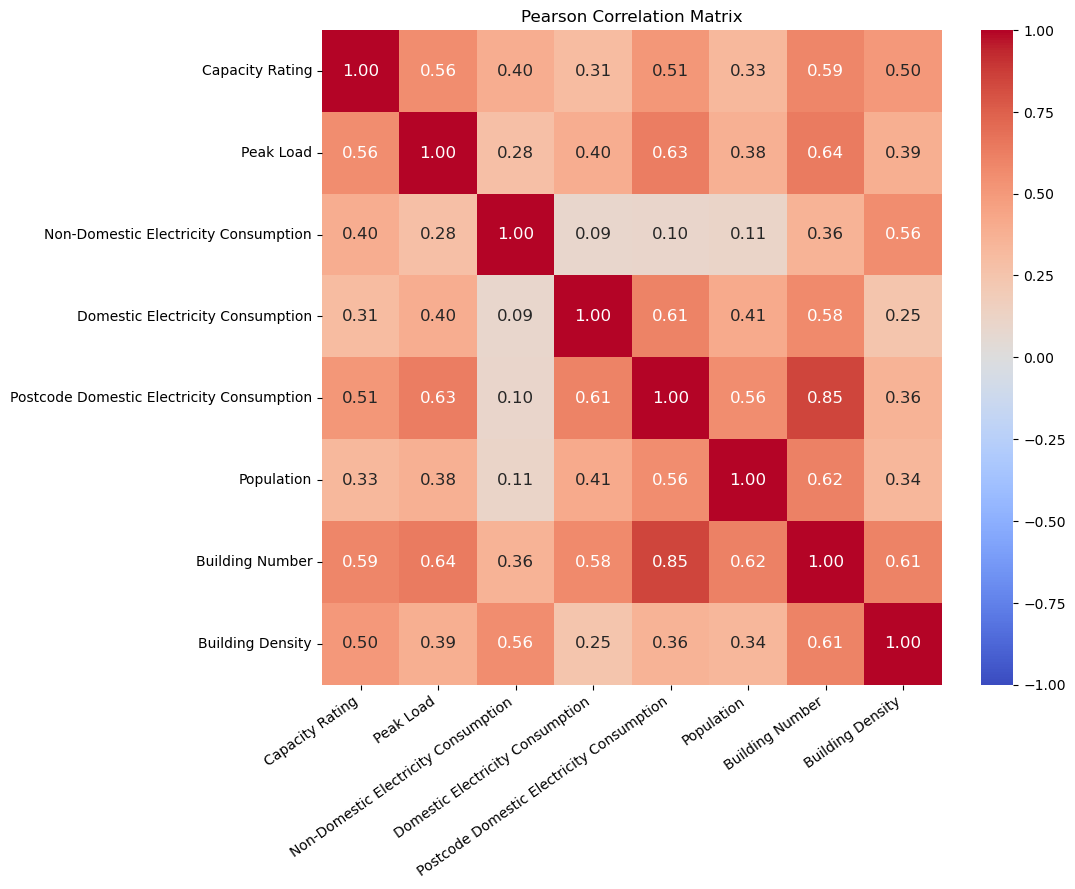

In [32]:
# targets with 6 features
columns = ['CapacityRating', 'peakload',
           'Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 
           'Consumption_postcode', 'Population_building', 'All building_num',
           'building_density_number']

features = ESA_features[columns]

# Rename the columns
new_column_names = {
    'CapacityRating': 'Capacity Rating',
    'peakload': 'Peak Load',
    'Non_Domestic_consumption_building_C': 'Non-Domestic Electricity Consumption',
    'Domestic_consumption_building': 'Domestic Electricity Consumption',
    'Consumption_postcode': 'Postcode Domestic Electricity Consumption',
    'Population_building': 'Population',
    'All building_num': 'Building Number',
    'building_density_number': 'Building Density'
}

features = features.rename(columns=new_column_names)

# Calculate the Pearson correlation matrix
correlation_matrix = features.corr(method='pearson')

# Visualize with heatmap
plt.figure(figsize=(10,8.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 12})

plt.xticks(rotation=35, ha='right')
plt.yticks(rotation=0)

plt.title('Pearson Correlation Matrix')
plt.show()

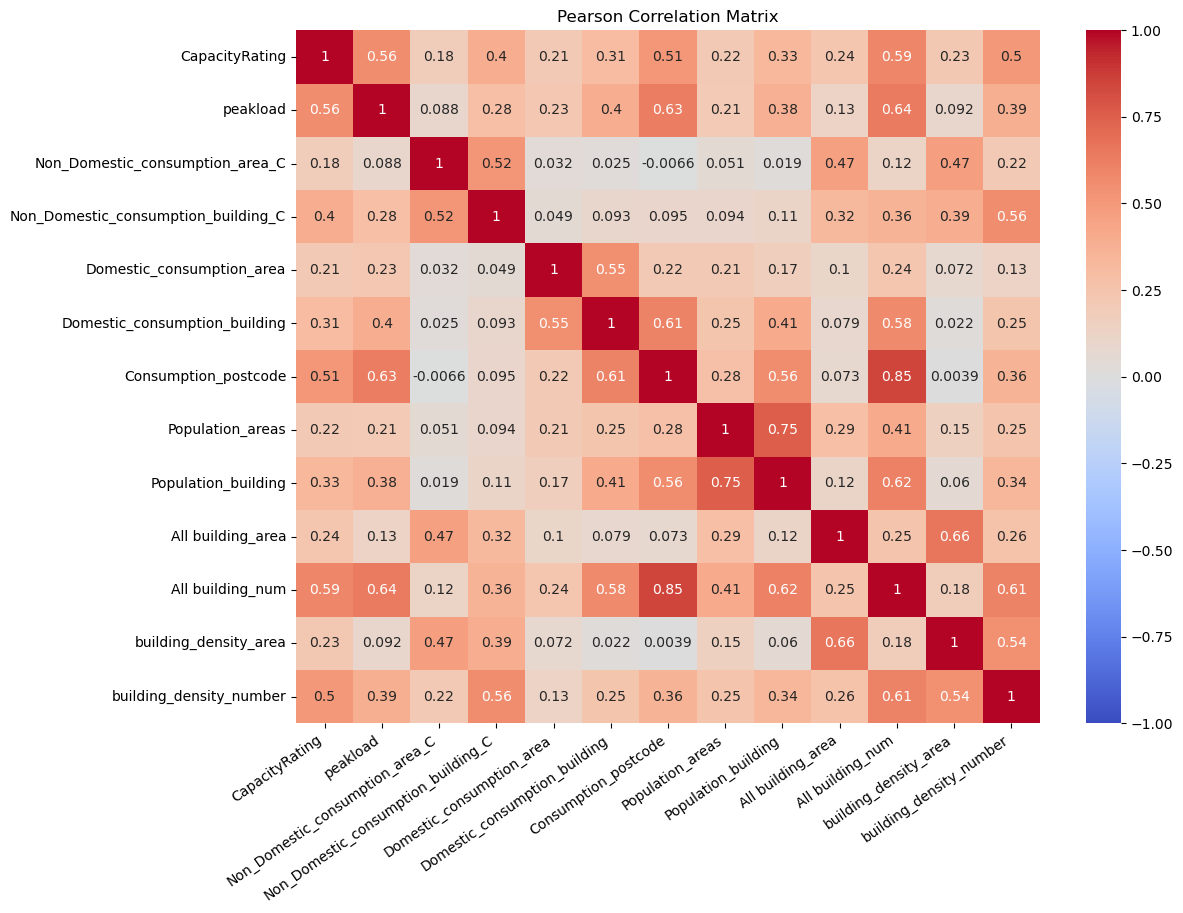

In [33]:
## show building number and area together
columns = ['CapacityRating', 'peakload',
           'Non_Domestic_consumption_area_C', 'Non_Domestic_consumption_building_C',
           'Domestic_consumption_area', 'Domestic_consumption_building', 
           'Consumption_postcode', 'Population_areas', 'Population_building',
           'All building_area', 'All building_num',
           'building_density_area', 'building_density_number']

# Calculate the Pearson correlation matrix
correlation_matrix = ESA_features[columns].corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12,9))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(rotation=35, ha='right')
plt.yticks(rotation=0)

plt.title('Pearson Correlation Matrix')
plt.show()

### Data split

In [34]:
ESA_missing = ESA_features[ESA_features['peakload'].isna()]
ESA_nonmissing = ESA_features[ESA_features['peakload'].notna()]
print(ESA_missing.shape[0])
print(ESA_nonmissing.shape[0])

1287
4720


In [35]:
ESA_nonmissing_1 = ESA_nonmissing[ESA_nonmissing['peakload'] <= 1000]

In [36]:
## Split the nonmissing dataset into train/val/test sets with 70/15/15

train_ESA, temp_ESA = train_test_split(ESA_nonmissing_1, test_size=0.3, random_state=128)
val_ESA, test_ESA = train_test_split(temp_ESA, test_size=0.5, random_state=128)

print(train_ESA.shape[0])
print(val_ESA.shape[0])
print(test_ESA.shape[0])

3303
708
708


In [37]:
train_ESA.to_file("train_ESA.gpkg", layer='train', driver="GPKG")
val_ESA.to_file("val_ESA.gpkg", layer='val', driver="GPKG")
test_ESA.to_file("test_ESA.gpkg", layer='test', driver="GPKG")

ESA_nonmissing_1.to_file("ESA_nonmissing.gpkg", layer='non-missing', driver="GPKG")
ESA_missing.to_file("ESA_missing.gpkg", layer='missing', driver="GPKG")